# Initial sea ice diagnostics

In [2]:
from aqua import Reader,catalogue, inspect_catalogue
import datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

FDB5 binary library not present on system, disabling FDB support.


In [3]:
cat = catalogue()

# Parameters,  to be moved in a YAML file eventually
                       # Region name          # southernmost latitude    # northernmost latitude   # westernmost longitude # easternmost longitude
regions = [ \
                       [ "Arctic",            [0.0,                      90.0,                     0.0,                    360.0                 ]], \
                       [ "Southern Ocean",    [-90.0,                    0.0,                      0.0,                    360.0                 ]], \
                       [ "Hudson Bay",        [50.0,                     63.0,                     265.0,                  285.0                 ]], \
                       [ "Ross Sea",          [-90.0,                    0.0,                      160.0,                  230.0                 ]], \
                       [ "Amundsen-Bellingshausen Seas", [-90.0,         0.0,                      230.0,                  300.0                 ]], \
                       [ "Weddell Sea",       [-90.0,                    0.0,                      300.0,                  20.0                  ]], \
                       [ "Indian Ocean",      [-90.0,                    0.0,                      20.0,                   90.0                  ]], \
                       [ "Pacific Ocean",     [-90.0,                    0.0,                      90.0,                   160.0                 ]], \
                    ]

thresholdSeaIceExtent = 0.15

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- interpolated_global	NN interpolation to 5400x2700 grid (lon=[-180,180], lat=[-90, 90])
	- lra-r100-monthly	LRA data monthly at r100
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	original 2d output
	- ICMU_atm2d	original 2d output (lnsp)
	- ICMU_atm3d	original 3d output
	- lra-r100-monthly	LRA data monthly at r100
IFS	test-tco2559	4km experiment, coupled with FESOM
	- ICMGG_atm2d	2d output
	- ICMU_atm3d	3d output
IFS	test-tco79	TCO79 test data
	- short	original 2d output
	- long	coarse IFS data 1y
IFS	tco25

In [15]:
# Exp specification
 
# Setups that work

#model = "IFS"
#exp   = "tco1279-orca025-cycle3"
#source= "lra-r100-monthly"
#dim1Name = "lon"
#dim2Name = "lat"
#regrid = "r100"
#computeGridCellAreas  = False
#rename = True
#fix = False

#model = "IFS"
#exp = "tco2559-ng5-cycle3"
#source = "2D_monthly_0.25deg" # works also with lra-r100-monthly"
#dim1Name = "lon"
#dim2Name = "lat"
#computeGridCellAreas  = False
#rename = True
#fix = False

#model = "IFS"
#exp = "tco1279-orca025-cycle3"
#source = "2D_monthly_0.25deg" # works also with 2D_monthly_native and lra-r100-monthly
#dim1Name = "lon"
#dim2Name = "lat"
#computeGridCellAreas  = False
#rename = True
#fix = False

#model = "ICON"
#exp = "ngc2009"
#source = "lra-r100-monthly"



# Produces weird results
#model   = "FESOM"
#exp     = "tco2559-ng5-cycle3" 
#source  = "lra-r100-monthly"
#rename = True


# No sea ice variables here
#model = "ICON"
#exp = "ngc3026"
#source = "lra-r100-monthly"

model = "OSI-SAF"
exp   = "osi-450"
source = "nh"
dim1Name = "yc"
dim2Name = "xc"
rename = False
fix   = True
regrid = "r100"
computeGridCellAreas = False


label = model + " " + exp + " " + source


In [16]:

# Instantiate reader
reader = Reader(model  = model, \
                exp    = exp,   \
                source = source,\
               )

data = reader.retrieve(fix    = fix,    \
                       regrid = regrid, \
                       startdate="2010-01-01", \
                       enddate="2015-12-31")
print(data)
# Renames
if rename:
    #if model == "IFS":
    #    data=data.rename({"ci":"siconc"})
    #elif model == "FESOM":
    #    data=data.rename({"a_ice":"siconc"})
    data=data.rename({"ci":"siconc"})

<xarray.Dataset>
Dimensions:                   (time: 11801, bnds: 2, yc: 432, xc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2...
    lon                       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat                       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
  * xc                        (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                        (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds                 (time, bnds) datetime64[ns] dask.array<chunksize=(179, 2), meta=np.ndarray>
    Lambert_Azimuthal_Grid    (time) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    siconc                    (time, yc, xc) float64 dask.array<chunksize=(179, 432, 432), meta=np.ndarray>
    raw_ice_conc_values       (time, yc, xc) float64 dask.array<chunksize=(179, 432, 432), meta=np.ndarray>
    total_s

In [17]:

# Compute grid cell areas from regular grid if needed
if computeGridCellAreas:
    # Create grid cell areas
    # Ensure that the grid is really regular
    if len(data.lon.shape) != 1 or len(data.lat.shape) != 1 \
      or len(set(np.diff(data.lon))) != 1 or len(set(np.diff(data.lat))) != 1:
        print("Lat and lon are not regular")
        stop()
    else:

        # Broadcast lat and lon to 2-D arrays
        lon, lat = xr.broadcast(data.lon, data.lat)

        dlam = np.diff(data.lon)[0] * 2 * np.pi / 360.0 # Degrees to radians
        dphi = np.diff(data.lat)[0] * 2 * np.pi / 360.0 # Degrees to radians

        phi = 2 * np.pi / 360.0 * data.lat
        lam = 2 * np.pi / 360.0 * data.lon

        # Expand grid
        lam, phi = xr.broadcast(data.lon / 360.0 * 2 * np.pi, data.lat / 360.0 * 2 * np.pi)
 

        Rearth = 6356e3 # meters

        areacello = np.cos(phi) * Rearth * dlam * Rearth * dphi / 1e12
        areacello = areacello.rename("areacello")
        areacello.attrs["units"] = "million km^2"
        areacello.attrs["standard_name"] = "Grid cell area"

        # Check that sum is within the true Earth surface
        trueEarthSurface = 510072000e6 # Wikipedia
        if np.abs((areacello.sum() - trueEarthSurface) / trueEarthSurface) > 0.01:
            print("Earth's surface wrongly calculated")
else:
    areacello = reader.grid_area
    lat = data.coords["lat"]
    lon = data.coords["lon"]

In [21]:
# Mask based on threshold
siconc_mask = data.siconc.where(data.siconc > thresholdSeaIceExtent).where(data.siconc < 1.0)



<xarray.DataArray 'time' (time: 11801)>
array(['1979-01-02T12:00:00.000000000', '1979-01-04T12:00:00.000000000',
       '1979-01-06T12:00:00.000000000', ..., '2015-12-29T12:00:00.000000000',
       '2015-12-30T12:00:00.000000000', '2015-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02T12:00:00 ... 2015-12-31T12:00:00
Attributes:
    standard_name:  time
    long_name:      reference time of product
    bounds:         time_bnds
    axis:           T

Producing diagnostic for region Arctic


KeyboardInterrupt: 

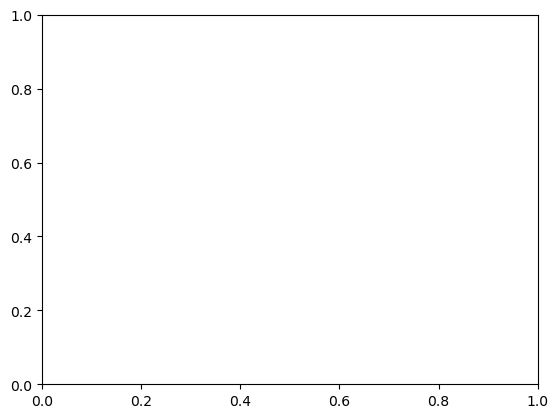

In [19]:
# Iterate over regions
for jr, region in enumerate(regions):

    print("Producing diagnostic for region " + region[0])
    # Create regional mask
    latS, latN, lonW, lonE = regions[jr][1][0], regions[jr][1][1], regions[jr][1][2], regions[jr][1][3]

    # Dealing with regions straddling the 180° meridian
    if lonW > lonE:
        regionMask = (lat >= latS) & (lat <= latN) & ((lon >= lonW) | (lon <= lonE))
    else:
        regionMask = (lat >= latS) & (lat <= latN) & (lon >= lonW) & (lon <= lonE)

    areacello_mask = areacello.where(regionMask)
  

    # Create masks for summing later on
    areacello_mask = areacello.where(regionMask)
    
    #extent = areacello.sum(dim = [dim1Name, dim2Name])
    if source == "lra-r100-monthly" or model == "OSI-SAF":
        extent = areacello.where(regionMask).where(siconc_mask.notnull()).sum(dim = [dim1Name, dim2Name]) / 1e12
    else:
        extent = areacello.where(regionMask).where(siconc_mask.notnull()).sum(dim = "value") / 1e12

    extent.attrs["units"] = "million km^2"
    extent.attrs["long_name"] = "Sea ice extent"
    # Print region area for information
    #areaRegion = areacello.where(regionMask).sum()
    #print(region[0] + " region area: " + str(areaRegion.data) + areaRegion.units)
    fig, ax = plt.subplots(1, 1)
    extent.plot(label = label)
    ax.grid()
    ax.legend()
    ax.set_title("Sea ice extent: region " + region[0])
    regionNameNoSpace = "".join(region[0].split())
    fig.savefig("./fig_" + regionNameNoSpace + ".png")



ValueError: x and y must have same first dimension, but have shapes (360,) and (180,)

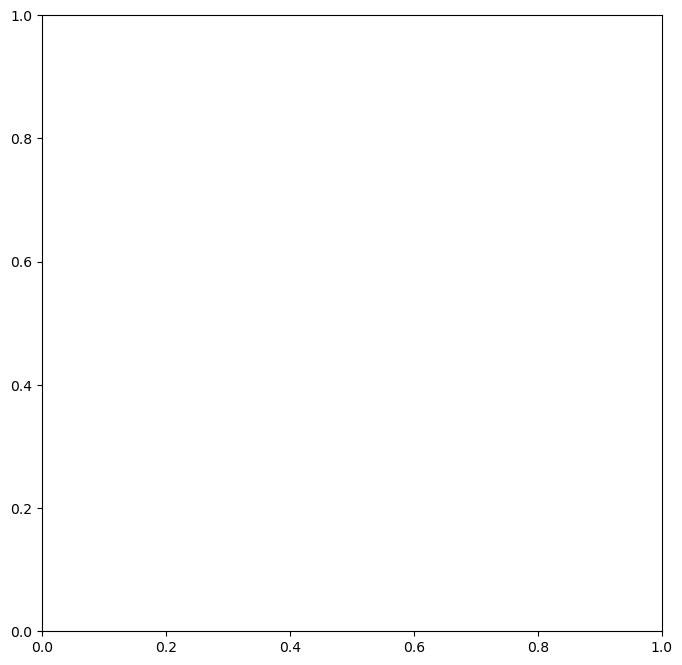

In [28]:
# A few maps
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


subplot_kws=dict(projection=ccrs.NorthPolarStereo(central_longitude=-30.0),
                 facecolor='grey')

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
p = ax.plot(lon,lat, data.siconc.mean(),
                  vmin=0, vmax=1,
                  cmap=plt.cm.Blues,
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

# add separate colorbar
cb = plt.colorbar(p, ticks=[-2,0,2,4,6,8,10,12], shrink=0.99)
cb.ax.tick_params(labelsize=18)

p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
p.axes.set_extent([-300, 60, 50, 90], ccrs.PlateCarree())